In [1]:
import numpy as np
from scipy.stats import linregress
import os
from ase.build import bulk
from calorine.calculators import CPUNEP
from calorine.tools import get_force_constants, relax_structure
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from pandas import DataFrame
from seekpath import get_explicit_k_path
from scipy.integrate import quad
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
plt.rcParams.update({
    'font.size': 16,
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 12
})

### Build silicon bulk structure

In [3]:
structure = bulk('Si', 'diamond', a=5.431)
calculator = CPUNEP('NEP/Si_2022_NEP3_3body.txt')
structure.calc = calculator
relax_structure(structure, fmax=0.0001)

### Compute force constants and phonon dispersion

In [4]:
phonon = get_force_constants(structure, calculator, [6, 6, 6])

structure_tuple = (structure.cell, structure.get_scaled_positions(), structure.numbers)

path = get_explicit_k_path(structure_tuple)
phonon.run_band_structure([path['explicit_kpoints_rel']])
band = phonon.get_band_structure_dict()

df = DataFrame(band['frequencies'][0])
df.index = path['explicit_kpoints_linearcoord']

path['explicit_kpoints_labels'] = path['explicit_kpoints_labels'][:147]
path['explicit_kpoints_linearcoord'] = path['explicit_kpoints_linearcoord'][:147]

### Run DOS calculation

In [5]:
phonon.run_mesh([160,160,160]) #
phonon.run_total_dos(freq_min=0, freq_max=15, freq_pitch=0.01)
dos = phonon.get_total_dos_dict()

frequencies_rad_ps = dos['frequency_points'] * 2 * np.pi
raw_dos = dos['total_dos']

### Normalize DOS such that ∫g(ω)dω = 3N

In [6]:
N_atoms = 8 / (5.43e-10)**3
total_modes = 3 * N_atoms
area = np.trapezoid(raw_dos, frequencies_rad_ps * 1e12)
normalized_dos = raw_dos * (total_modes / area)

### Save normalized DOS to file

In [7]:
os.makedirs('DOS', exist_ok=True)
with open('DOS/DOS_Bulk_nep.txt', 'w') as f:
    f.write("# Frequency (rad/s)   DOS (states / (rad/s·m³))\n")
    for omega, g in zip(frequencies_rad_ps, normalized_dos):
        f.write(f"{omega:.6e}    {g:.6e}\n")

### Plot dispersion and DOS

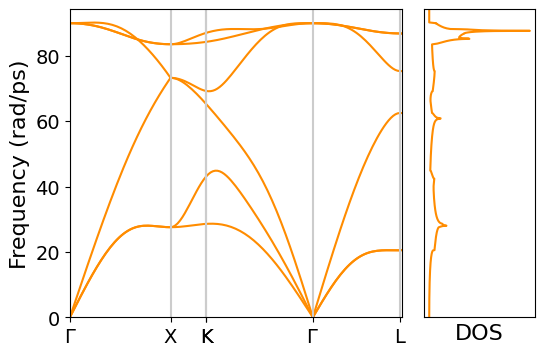

In [8]:
os.makedirs('Fig', exist_ok=True)
fig = plt.figure(figsize=(6, 4))
gs = GridSpec(1, 2, width_ratios=[3, 1], wspace=0.1)

ax1 = fig.add_subplot(gs[0])
for col in df.columns:
    ax1.plot(df.index, df[col] * 2 * np.pi, '-', color='darkorange')  # THz -> rad/ps
ax1.set_ylabel('Frequency (rad/ps)')
ax1.set_xlim(0, 3.8)
labels = [r'$\Gamma$' if m == 'GAMMA' else m for m in path['explicit_kpoints_labels']]
df_path = DataFrame({'labels': labels, 'positions': path['explicit_kpoints_linearcoord']})
df_path = df_path[df_path.labels != '']
ax1.set_xticks(df_path.positions)
ax1.set_xticklabels(df_path.labels)
for xp in df_path.positions:
    ax1.axvline(xp, color='0.8')

ax2 = fig.add_subplot(gs[1], sharey=ax1)
ax2.plot(normalized_dos, frequencies_rad_ps, color='darkorange')
ax2.set_ylim(0, np.max(frequencies_rad_ps))
ax2.set_xlabel('DOS')
ax2.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

plt.savefig('Fig/band_and_dos_bulk.png')
plt.show()

### Constants

In [9]:
hbar = 1.0545718e-34   # J·s
kB = 1.380649e-23      # J/K
NA = 6.02214076e23     # Avogadro constant
THz_to_rad = 2 * np.pi * 1e12

# Temperature range
T_range = np.logspace(np.log10(5), 3, 1000)

### Cv from DOS

In [10]:
dos = normalized_dos[1:]
omega = frequencies_rad_ps[1:] * 1e12

cv_dos = []
for T in T_range:
    x = hbar * omega / (kB * T)
    exp_neg_x = np.exp(-x)
    bose_fator = exp_neg_x / (1 - exp_neg_x)**2
    integrand = kB * dos * x**2 * bose_fator
    cv = np.trapezoid(integrand, omega)
    cv_dos.append(cv)

### Cv from Debye model

In [11]:
rho = 2330            # density (kg/m³)
M = 28.0855e-3        # molar mass (kg/mol)
vs = 6400             # average sound speed (m/s)
k_D = (6 * np.pi**2 * N_atoms) ** (1/3)
omega_D = vs * k_D             # rad/s
theta_D = hbar * omega_D / kB  # K
Vm = M / rho                   # molar volume (m³/mol)
R = 8.3144621                  # gas constant (J/mol/K)

In [12]:
def debye_integrand(x):
    return x**4 * np.exp(x) / (np.exp(x) - 1)**2

cv_debye = []
for T in T_range:
    if T == 0:
        cv_vol = 0
    else:
        upper = theta_D / T
        integral, _ = quad(debye_integrand, 0, upper)
        cv_mol = 9 * R * (T / theta_D)**3 * integral  # J/mol·K
        cv_vol = cv_mol / Vm                          # J/m³·K
    cv_debye.append(cv_vol)

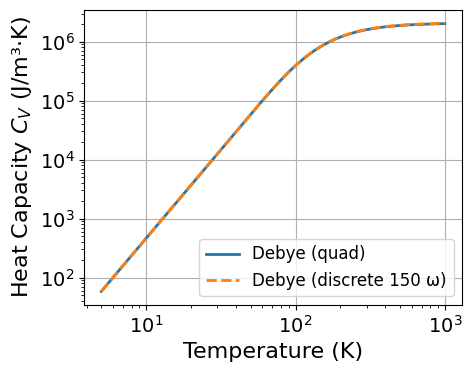

In [13]:
cv_debye_discrete = []
x_list = np.linspace(1/150, 1, 150)  # 归一化变量：x = ħω / kT = ω/ω_D * θ_D/T

for T in T_range:
    if T == 0:
        cv_vol = 0
    else:
        upper = theta_D / T
        x_scaled = x_list * upper
        dx = x_scaled[1] - x_scaled[0]
        integrand = x_scaled**4 * np.exp(x_scaled) / (np.exp(x_scaled) - 1)**2
        integral = np.sum(integrand) * dx
        cv_mol = 9 * R * (T / theta_D)**3 * integral
        cv_vol = cv_mol / Vm
    cv_debye_discrete.append(cv_vol)

# === 绘图比较 ===
plt.figure(figsize=(5, 4))
plt.loglog(T_range, cv_debye, label='Debye (quad)', lw=2)
plt.loglog(T_range, cv_debye_discrete, '--', label='Debye (discrete 150 ω)', lw=2)
plt.xlabel('Temperature (K)')
plt.ylabel('Heat Capacity $C_V$ (J/m³·K)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Save Cv data

In [14]:
output_path = 'Cv/Cv_bulk.txt'
os.makedirs(os.path.dirname(output_path), exist_ok=True)

with open(output_path, 'w') as f:
    f.write("Temperature (K),Cv_Debye (J/m3·K),Cv_NEP (J/m3·K)\n")
    for T, c_debye, c_dos in zip(T_range, cv_debye, cv_dos):
        f.write(f"{T:.6e},{c_debye:.6e},{c_dos:.6e}\n")


### Sliding window power-law exponent fitting

In [15]:
def sliding_power_law_fit(T_array, Cv_array, window=5):
    """Fit local power-law exponent n for each T using a sliding window"""
    T_array = np.asarray(T_array)
    Cv_array = np.asarray(Cv_array)

    n_list = np.full_like(T_array, np.nan, dtype=float)  # Output n values
    
    for i in range(window//2, len(T_array) - window//2):
        T_win = T_array[i - window//2: i + window//2 + 1]
        Cv_win = Cv_array[i - window//2: i + window//2 + 1]
        
        if len(T_win) < 2 or np.any(Cv_win <= 0):
            continue  # Skip if not enough points or invalid Cv

        logT = np.log(T_win)
        logCv = np.log(Cv_win)
        slope, _, _, _, _ = linregress(logT, logCv)
        n_list[i] = slope  # assign fitted slope (n) to center point

    return n_list

nT_nep = sliding_power_law_fit(T_range, cv_dos, window=5)
nT_debye = sliding_power_law_fit(T_range, cv_debye, window=5)

### Save power-law exponent results

In [16]:
output_path = 'n/n_bulk.txt'
os.makedirs(os.path.dirname(output_path), exist_ok=True)

with open(output_path, 'w') as f:
    f.write("Temperature (K),n_Debye,n_NEP\n")
    for T, n_debye, n_nep in zip(T_range, nT_debye, nT_nep):
        f.write(f"{T:.6e},{n_debye:.6e},{n_nep:.6e}\n")

### Plot Cv comparison and fitted exponent n

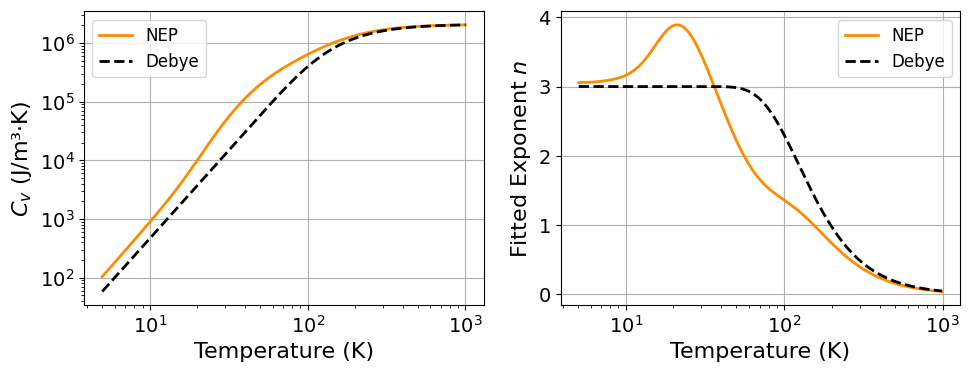

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))  # 一行两列

# === 图1: Cv vs Temperature（log-log）===
ax[0].loglog(T_range, cv_dos, '-', lw=2, color='darkorange', label='NEP')
ax[0].loglog(T_range, cv_debye, '--', lw=2, color='black', label='Debye')
ax[0].set_xlabel('Temperature (K)')
ax[0].set_ylabel(r'$C_v$ (J/m³·K)')
ax[0].grid(True)
ax[0].legend()

# === 图2: n vs Temperature（semilog-x）===
ax[1].semilogx(T_range, nT_nep, '-', lw=2, color='darkorange', label='NEP')
ax[1].semilogx(T_range, nT_debye, '--', lw=2, color='black', label='Debye')
ax[1].set_xlabel('Temperature (K)')
ax[1].set_ylabel('Fitted Exponent $n$')
ax[1].grid(True)
ax[1].legend()

plt.tight_layout()
plt.savefig("Fig/n_bulk.png", dpi=300)
plt.show()

### Cumulative Cv(omega) comparison (NEP vs Debye)

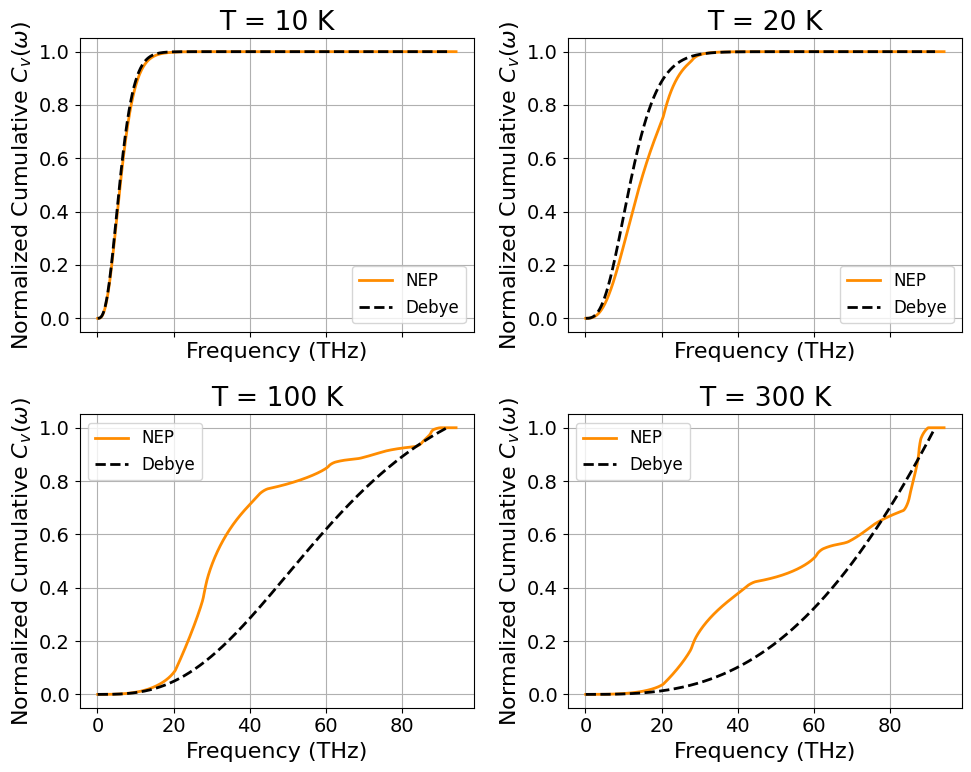

In [18]:
import os

# 创建保存文件的文件夹
os.makedirs("Cv", exist_ok=True)

T_list = [10, 20, 100, 300]
fig, axs = plt.subplots(2, 2, figsize=(10, 8), sharex=True)

omega_debye = np.linspace(omega[0], omega_D, len(omega))
dos_debye = 3 * N_atoms * omega_debye**2 / np.trapezoid(omega_debye**2, omega_debye)

for ax_idx, T_target in enumerate(T_list):
    ax = axs[ax_idx // 2, ax_idx % 2]

    # NEP cumulative Cv(ω)
    x = hbar * omega / (kB * T_target)
    bose_factor = np.exp(x) / (np.exp(x) - 1)**2
    Cv_omega = kB * dos * x**2 * bose_factor
    Cv_omega_cum = np.cumsum(Cv_omega) * np.gradient(omega)
    Cv_omega_cum /= Cv_omega_cum[-1]  # 归一化

    # Debye cumulative Cv(ω)
    x_debye = hbar * omega_debye / (kB * T_target)
    bose_factor_debye = np.exp(x_debye) / (np.exp(x_debye) - 1)**2
    Cv_omega_debye = kB * dos_debye * x_debye**2 * bose_factor_debye
    Cv_omega_debye_cum = np.cumsum(Cv_omega_debye) * np.gradient(omega_debye)
    Cv_omega_debye_cum /= Cv_omega_debye_cum[-1]  # 归一化

    # 保存到文件
    filename = f"Cv/cumulative_Cv_T{T_target}K.txt"
    data = np.column_stack((omega / 1e12, Cv_omega_cum, omega_debye / 1e12, Cv_omega_debye_cum))
    header = "omega(NEP)_THz  Cv_cum(NEP)  omega(Debye)_THz  Cv_cum(Debye)"
    np.savetxt(filename, data, header=header, fmt="%.6e")

    # Plot
    ax.plot(omega / 1e12 , Cv_omega_cum, label="NEP", lw=2, color='darkorange')
    ax.plot(omega_debye / 1e12 , Cv_omega_debye_cum, label="Debye", lw=2, ls='--', color='black')

    ax.set_title(f"T = {T_target} K")
    ax.set_xlabel("Frequency (THz)")
    ax.set_ylabel("Normalized Cumulative $C_v(\\omega)$")
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.savefig("Fig/cumulative_Cv_vs_freq_normalized.png", dpi=300)
plt.show()



In [19]:
### Run DOS calculation at different mesh densities
mesh_list = [40, 80, 120, 160]
cv_dos_dict = {}
nT_nep_dict = {}
dos_dict = {}

for mesh in mesh_list:
    phonon.run_mesh([mesh, mesh, mesh])
    phonon.run_total_dos(freq_min=0, freq_max=15, freq_pitch=0.01)
    dos = phonon.get_total_dos_dict()
    
    frequencies_rad_ps = dos['frequency_points'] * 2 * np.pi
    raw_dos = dos['total_dos']
    
    # Normalize DOS
    area = np.trapezoid(raw_dos, frequencies_rad_ps * 1e12)
    normalized_dos = raw_dos * (total_modes / area)
    
    # Compute Cv using NEP DOS
    dos_trim = normalized_dos[1:]
    omega_trim = frequencies_rad_ps[1:] * 1e12

    dos_dict[mesh] = dos_trim

    cv_dos = []
    for T in T_range:
        x = hbar * omega_trim / (kB * T)
        exp_neg_x = np.exp(-x)
        bose_fator = exp_neg_x / (1 - exp_neg_x)**2
        integrand = kB * dos_trim * x**2 * bose_fator
        cv = np.trapezoid(integrand, omega_trim)
        cv_dos.append(cv)
    
    # Store Cv for this mesh
    cv_dos_dict[mesh] = np.array(cv_dos)

    # Power-law exponent
    nT_nep_dict[mesh] = sliding_power_law_fit(T_range, cv_dos, window=5)


In [20]:
### Run DOS calculation at different Freq_pitch
freq_pitchs = [0.2, 0.1, 0.05, 0.01]
cv_dos_dict2 = {}
nT_nep_dict2 = {}
dos_dict = {}

for freq_pitch in freq_pitchs:
    phonon.run_mesh([160, 160, 160])
    phonon.run_total_dos(freq_min=0, freq_max=15, freq_pitch=freq_pitch)
    dos = phonon.get_total_dos_dict()
    
    frequencies_rad_ps = dos['frequency_points'] * 2 * np.pi
    raw_dos = dos['total_dos']
    
    # Normalize DOS
    area = np.trapezoid(raw_dos, frequencies_rad_ps * 1e12)
    normalized_dos = raw_dos * (total_modes / area)
    
    # Compute Cv using NEP DOS
    dos_trim = normalized_dos[1:]
    omega_trim = frequencies_rad_ps[1:] * 1e12

    dos_dict[freq_pitch] = dos_trim

    cv_dos = []
    for T in T_range:
        x = hbar * omega_trim / (kB * T)
        exp_neg_x = np.exp(-x)
        bose_fator = exp_neg_x / (1 - exp_neg_x)**2
        integrand = kB * dos_trim * x**2 * bose_fator
        cv = np.trapezoid(integrand, omega_trim)
        cv_dos.append(cv)
    
    # Store Cv for this mesh
    cv_dos_dict2[freq_pitch] = np.array(cv_dos)

    # Power-law exponent
    nT_nep_dict2[freq_pitch] = sliding_power_law_fit(T_range, cv_dos, window=5)

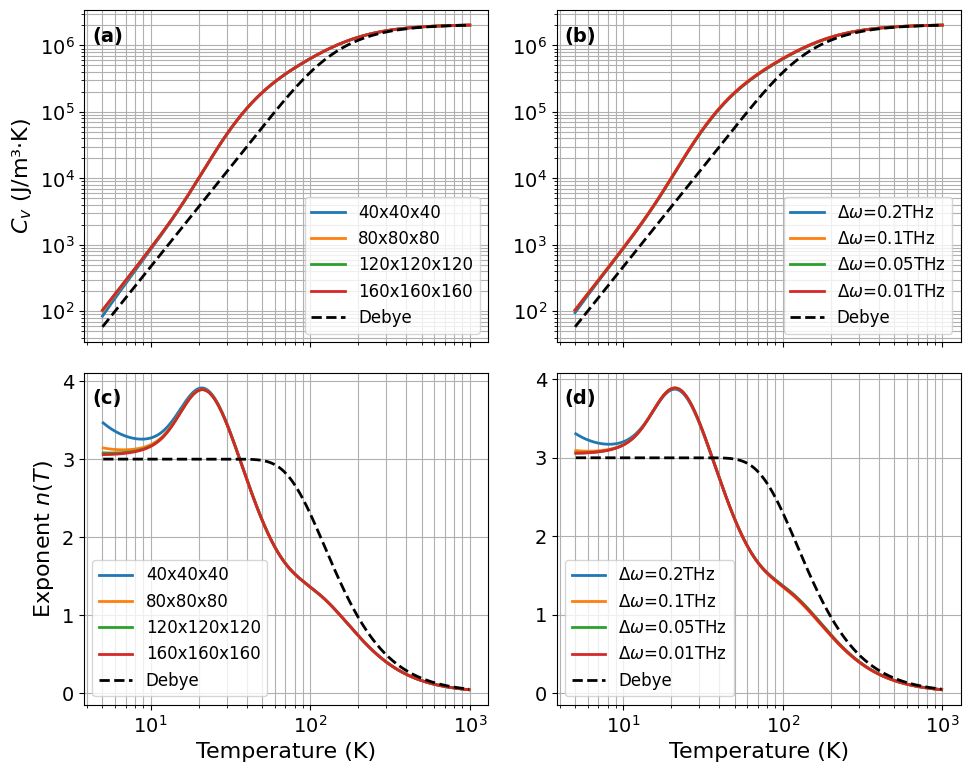

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8), sharex=True)

colors_mesh = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
colors_pitch = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

ax = axs[0, 0]
for i, mesh in enumerate(mesh_list):
    ax.loglog(T_range, cv_dos_dict[mesh], lw=2, label=rf"{mesh}x{mesh}x{mesh}", color=colors_mesh[i])
ax.loglog(T_range, cv_debye, '--', lw=2, color='black', label='Debye')
ax.set_ylabel(r'$C_v$ (J/m³·K)')
ax.grid(True, which='both')
ax.legend()

ax = axs[0, 1]
for i, pitch in enumerate(freq_pitchs):
    ax.loglog(T_range, cv_dos_dict2[pitch], lw=2, label=rf"$\Delta\omega$={pitch}THz", color=colors_pitch[i])
ax.loglog(T_range, cv_debye, '--', lw=2, color='black', label='Debye')
ax.grid(True, which='both')
ax.legend()

ax = axs[1, 0]
for i, mesh in enumerate(mesh_list):
    ax.semilogx(T_range, nT_nep_dict[mesh], lw=2, label=rf"{mesh}x{mesh}x{mesh}", color=colors_mesh[i])
ax.semilogx(T_range, nT_debye, '--', lw=2, color='black', label="Debye")
ax.set_xlabel('Temperature (K)')
ax.set_ylabel(r'Exponent $n(T)$')
ax.grid(True, which='both')
ax.legend()

ax = axs[1, 1]
for i, pitch in enumerate(freq_pitchs):
    ax.semilogx(T_range, nT_nep_dict2[pitch], lw=2, label=rf"$\Delta\omega$={pitch}THz", color=colors_pitch[i])
ax.semilogx(T_range, nT_debye, '--', lw=2, color='black', label="Debye")
ax.set_xlabel('Temperature (K)')
ax.grid(True, which='both')
ax.legend()

# 添加子图标签
labels = ['(a)', '(b)', '(c)', '(d)']
for i in range(2):
    for j in range(2):
        axs[i, j].text(0.02, 0.95, labels[i * 2 + j],
                       transform=axs[i, j].transAxes,
                       fontsize=14, fontweight='bold',
                       va='top', ha='left')

plt.tight_layout()
plt.savefig("Fig/Cv_nT_mesh_pitch_comparison.png", dpi=300)
plt.show()
